<img src="./images/ub_si.png" height="225" width="100%" />

# **N. W. Kusuma** || **`Big Data Final Exam`**

***
# **Libraries**
***
### Import common libraries

In [4]:
import pandas as pd 
import numpy as np 
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline 

### Setting compiler options
***

In [5]:
import warnings
#warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
print(os.listdir("./datasets"))

import xlrd

plt.style.use('bmh')
sns.set_style('whitegrid')
pd.set_option("display.float_format", '{:.2f}'.format)


['UAS_PCA dan Multi Linear Regression.xlsx', 'UAS_RFM.xlsx', 'UAS_SVM.xlsx']


***
# **Data Understanding**
***
## Load data files (`UAS_RFM.xlsx`)

In [3]:
dataset = pd.read_excel("./datasets/UAS_RFM.xlsx")
dataset.head()

,CardID,TrxDate,Amount
0,1000152,2021-05-19,932841
1,1000158,2021-03-25,881117
2,1000156,2021-04-25,368989
3,1000115,2021-06-14,621767
4,1000164,2021-01-02,451551


## Data inspections
***
### Inspect data structures, data desciption summary, and missing values

In [12]:
def inspect_data(df, note=None):
      try:
            pd.set_option("display.width", 100)
            print(f"\n{'*'*91}")
            print(f"The Permata Bank Credit Card usage in transactions at Giant Superstore franchises\n{'='*91}\n\t"
                  f"The data contains of `{df.shape[0]}` entries and `{df.shape[1]}` columns.\n{'-'*91}\n\t"      
                  f"Columns:\t\tDatatypes:\t\tMissing values:")
            for i in range(len(df.columns)):
                  if (len(df.columns.values[i])) >= 16: s = '\t'
                  elif (len(df.columns.values[i])) >= 8: s = '\t\t'
                  else: s = '\t\t\t'
                  if (len(np.dtype(df.iloc[:,i]).str) + 2) >= 16: t = '\t'
                  elif (len(np.dtype(df.iloc[:,i]).str) + 2) >= 8: t = '\t\t'
                  else: t = '\t\t\t'
                  print(f"\t{df.columns.values[i]}{s}{np.dtype(df.iloc[:,i])}{t}{df.iloc[:,i].isnull().sum()} value") 
            print(f"{'-'*91}\n{df.describe().T}")
      finally:
            if note != None: print(f"{'='*91}\nNote:\n{note}\n{'*'*91}")
            else: print('*'*91)
            pd.reset_option("display.width")

In [17]:
note = f"All transactions occurs within the periode of `{dataset.TrxDate.min().date()}` to `{dataset.TrxDate.max().date()}`"
inspect_data(dataset, note)


*******************************************************************************************
The Permata Bank Credit Card usage in transactions at Giant Superstore franchises
	The data contains of `199` entries and `3` columns.
-------------------------------------------------------------------------------------------
	Columns:		Datatypes:		Missing values:
	CardID			int64			0 value
	TrxDate			datetime64[ns]		0 value
	Amount			int64			0 value
-------------------------------------------------------------------------------------------
        count       mean       std        min        25%        50%        75%        max
CardID 199.00 1000136.91     20.79 1000101.00 1000116.50 1000138.00 1000155.00 1000174.00
Amount 199.00  537107.41 282221.55   54662.00  284502.00  579182.00  795240.50  998878.00
Note:
All transactions occurs within the periode of `2021-01-01` to `2021-06-30`
*******************************************************************************************


In [18]:
print(dataset['CardID'].unique())

[1000152 1000158 1000156 1000115 1000164 1000136 1000147 1000118 1000167
 1000160 1000150 1000143 1000133 1000170 1000111 1000102 1000105 1000130
 1000127 1000113 1000172 1000112 1000157 1000148 1000138 1000166 1000140
 1000146 1000134 1000154 1000142 1000125 1000108 1000109 1000106 1000161
 1000128 1000145 1000163 1000101 1000135 1000155 1000159 1000104 1000120
 1000124 1000117 1000141 1000110 1000153 1000139 1000168 1000126 1000162
 1000103 1000151 1000119 1000169 1000122 1000116 1000114 1000174 1000149
 1000132 1000137 1000107 1000131 1000171 1000144 1000129 1000121]


***
# **Data Preparation**
***
## Aggregate data at customer level
- #### `Recency`: today date - last order date by each customer 
- #### `Frequency`: the count of unique order/invoice by each customer
- #### `Monetary`: the total amount (sum) of paid expenses by each customer

In [19]:
# Import datetime library
from datetime import datetime, timedelta

In [20]:
today = dataset['TrxDate'].max().date() + timedelta(days=1)
#dataset['Trans'] = dataset[['CardID']]
df_trans = dataset.groupby('CardID').agg({'TrxDate': lambda x: (today - x.max().date()).days,                         
                                           'CardID': lambda x: x.count(),  
                                           'Amount': lambda x: x.sum()})
df_trans.columns = ['Recency', 'Frequency', 'Monetary']
df_trans.head().sort_values('Recency', ascending=False)


,Recency,Frequency,Monetary
CardID,,,
1000101,88,1,203955
1000104,43,2,612707
1000103,31,1,696250
1000102,19,3,2120942
1000105,1,5,2590460


In [21]:
note = "The `50` and `75` percentile of `Frequency` has equal value, this will pose a problem when \nbinning the data into `R`, `F`, and `M` Score."
inspect_data(df_trans, note)


*******************************************************************************************
The Permata Bank Credit Card usage in transactions at Giant Superstore franchises
	The data contains of `71` entries and `3` columns.
-------------------------------------------------------------------------------------------
	Columns:		Datatypes:		Missing values:
	Recency			int64			0 value
	Frequency		int64			0 value
	Monetary		int64			0 value
-------------------------------------------------------------------------------------------
           count       mean        std       min       25%        50%        75%        max
Recency    71.00      59.61      46.86      1.00     27.50      45.00      89.00     174.00
Frequency  71.00       2.80       1.60      1.00      2.00       3.00       3.00       7.00
Monetary   71.00 1505413.73 1098111.75 101383.00 722176.50 1209115.00 2005925.00 4816552.00
Note:
The `50` and `75` percentile of `Frequency` has equal value, this will pose a problem when 
bi

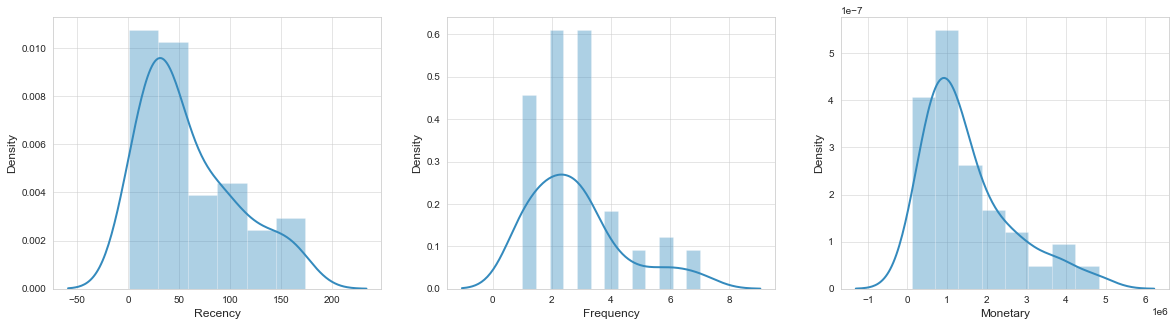

In [22]:
# Plot RFM distributions
plt.figure(figsize=(20,5))
# Plot distribution of R
plt.subplot(1, 3, 1); sns.distplot(df_trans['Recency'])
# Plot distribution of F
plt.subplot(1, 3, 2); sns.distplot(df_trans['Frequency'])
# Plot distribution of M
plt.subplot(1, 3, 3); sns.distplot(df_trans['Monetary'])
# Show the plot
plt.show()

***
# **Recency, Frequency, and Monetary score**
***
#### Segregate `Recency`, `Frequency`, and `Monetary` values into discrete values and classify them into categorical order

In [23]:
def RFM_Quartile (df, rfm, rev=False):
    if (rev == True):
      lbl = [4, 3, 2, 1]
    else: lbl = [1, 2, 3, 4]

    return (pd.cut(df[rfm], 
                   bins=[-1, np.percentile(df[rfm], 25),
                             np.percentile(df[rfm], 50),
                             np.percentile(df[rfm], 75),
                             df[rfm].max()], 
                   labels=lbl).astype("int"))      

In [24]:
# Recency score: Days since last purchase.
df_trans['R_Score'] = RFM_Quartile(df_trans, "Recency", True )
                                    
# Frequency score: Total number of orders.
#df_trans["F_Score"] = RFM_Quartile(df_trans, "Frequency")
df_trans["F_Score"] = pd.cut(df_trans["Frequency"], 
                             bins=[-1, np.percentile(df_trans["Frequency"], 25), 
                                    np.percentile(df_trans["Frequency"], 50), 
                                    4, # because 50 and 75 percentile has the same value. 
                                    df_trans["Frequency"].max()], 
                             labels=[1, 2, 3, 4]).astype("int")

# Monetary score: Total paid expenses.
df_trans["M_Score"] = RFM_Quartile(df_trans, "Monetary")

df_trans.head().sort_values('Monetary', ascending=False)

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
CardID,,,,,,
1000105,1,5,2590460,4,4,4
1000102,19,3,2120942,4,2,4
1000103,31,1,696250,3,1,1
1000104,43,2,612707,3,1,1
1000101,88,1,203955,2,1,1


***
# **RFM score**
***
#### The combined (concatenated) score of Recency, Frequency, and Monetary scores

In [25]:
#df_trans["RFM_Score"] = ((df_trans["R_Score"].map(str)) + 
                         #(df_trans["F_Score"].map(str)) + 
                          #df_trans["M_Score"].map(str))
df_trans["RFM_Score"] = ((df_trans["R_Score"] * 100) + 
                         (df_trans["F_Score"] * 10) + 
                          df_trans["M_Score"])

df_trans.head().sort_values('RFM_Score', ascending=False)

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
CardID,,,,,,,
1000105,1,5,2590460,4,4,4,444
1000102,19,3,2120942,4,2,4,424
1000103,31,1,696250,3,1,1,311
1000104,43,2,612707,3,1,1,311
1000101,88,1,203955,2,1,1,211


***
# **Labeling**
***
#### Labeling based on RFM scores

In [26]:
conditions = [
# "Premium Customers" ----------------------------------------------
            (df_trans["RFM_Score"] == 444), 
# "Loyal Customers" ------------------------------------------------
            (df_trans["RFM_Score"] == 443) 
                | (df_trans["RFM_Score"] == 434) 
                    | (df_trans["RFM_Score"] == 433) |
            (df_trans["RFM_Score"] == 344) 
                | (df_trans["RFM_Score"] == 343) 
                    | (df_trans["RFM_Score"] == 334), 
# "Frequent Buyers" -----------------------------------------------
            (df_trans["RFM_Score"] == 442) 
                | (df_trans["RFM_Score"] == 441)
                    | (df_trans["RFM_Score"] == 342) 
                        | (df_trans["RFM_Score"] == 341) | 
            (df_trans["RFM_Score"] == 432) 
                | (df_trans["RFM_Score"] == 431)
                    | (df_trans["RFM_Score"] == 333)
                        | (df_trans["RFM_Score"] == 332) 
                            | (df_trans["RFM_Score"] == 331),
# "Big Spenders" --------------------------------------------------
            (df_trans["RFM_Score"] == 424) 
                | (df_trans["RFM_Score"] == 414) 
                    | (df_trans["RFM_Score"] == 324) 
                        | (df_trans["RFM_Score"] == 314) |
            (df_trans["RFM_Score"] == 423) 
                | (df_trans["RFM_Score"] == 413) 
                    | (df_trans["RFM_Score"] == 323) 
                        | (df_trans["RFM_Score"] == 313), 
# "Promising New Customers" ---------------------------------------
            (df_trans["RFM_Score"] == 422) 
                | (df_trans["RFM_Score"] == 421)
                    | (df_trans["RFM_Score"] == 412) 
                        | (df_trans["RFM_Score"] == 411) |
            (df_trans["RFM_Score"] == 322) 
                | (df_trans["RFM_Score"] == 321)
                    | (df_trans["RFM_Score"] == 312) 
                        | (df_trans["RFM_Score"] == 311),
# "Inactive Frequent Buyers" --------------------------------------
            (df_trans["RFM_Score"] == 244) 
                | (df_trans["RFM_Score"] == 243) 
                    | (df_trans["RFM_Score"] == 242) 
                        | (df_trans["RFM_Score"] == 241) |
            (df_trans["RFM_Score"] == 144) 
                | (df_trans["RFM_Score"] == 143) 
                    | (df_trans["RFM_Score"] == 142) 
                        | (df_trans["RFM_Score"] == 141) |
            (df_trans["RFM_Score"] == 232) 
                | (df_trans["RFM_Score"] == 231)
                    | (df_trans["RFM_Score"] == 132) 
                        | (df_trans["RFM_Score"] == 131),
# "Inactive High Value" -------------------------------------------
            (df_trans["RFM_Score"] == 234) 
                | (df_trans["RFM_Score"] == 224) 
                    | (df_trans["RFM_Score"] == 214) 
                        | (df_trans["RFM_Score"] == 134) 
                            | (df_trans["RFM_Score"] == 124) |
            (df_trans["RFM_Score"] == 233)
                | (df_trans["RFM_Score"] == 223) 
                    | (df_trans["RFM_Score"] == 213)
                        | (df_trans["RFM_Score"] == 133)
                            | (df_trans["RFM_Score"] == 123), 
# "Inactive Customers" --------------------------------------------
            (df_trans["RFM_Score"] == 222) 
                | (df_trans["RFM_Score"] == 221)
                    | (df_trans["RFM_Score"] == 212)
                        | (df_trans["RFM_Score"] == 211),
# "Lost Customers" ------------------------------------------------
            (df_trans["RFM_Score"] == 122) 
                | (df_trans["RFM_Score"] == 121)
                    | (df_trans["RFM_Score"] == 114) 
                        | (df_trans["RFM_Score"] == 113) 
                            | (df_trans["RFM_Score"] == 112)
# "Lost Cheap Customers" ------------------------------------------
                | (df_trans["RFM_Score"] == 111)]

In [27]:
mappings = ["01 Premium Customers", 
            "02 Loyal Customers", 
            "03 Frequent Buyers", 
            "04 Big Spenders", 
            "05 Promising New Cust.", 
            "06 Inactive Frequent",
            "07 Inactive High Value",
            "08 Cheap Customers",
            "09 Lost Customers"]

df_trans["RFM_Segment"] = np.select(conditions, mappings, default="09-Lost Customers")
df_trans["RFM_Segment"].value_counts()

05 Promising New Cust.    14
09 Lost Customers         14
07 Inactive High Value    11
08 Cheap Customers         9
04 Big Spenders            9
02 Loyal Customers         7
01 Premium Customers       5
03 Frequent Buyers         1
06 Inactive Frequent       1
Name: RFM_Segment, dtype: int64

***
# **Promotion**
***
#### Promotion strategy based on Labels

In [28]:
promotions = ["01 New Product & Loyalty programs", 
              "02 Priced Bundling & Loyalty programs",
              "03 Mixed Bundling & Discount Sale",
              "04 New Product & Priced Bundling",
              "05 Point Rewards & Discount Sale",
              "06 Returning Offers & Discount Sale",
              "07 Returning Offers & New Product",
              "08 Login Offers & Agressive Discount",
              "09 Don't bother to reaquire"]

df_trans["Promotion"] = np.select(conditions, promotions, default="09 Don't bother to reaquire")
df_trans["Promotion"].value_counts()

09 Don't bother to reaquire              14
05 Point Rewards & Discount Sale         14
07 Returning Offers & New Product        11
08 Login Offers & Agressive Discount      9
04 New Product & Priced Bundling          9
02 Priced Bundling & Loyalty programs     7
01 New Product & Loyalty programs         5
06 Returning Offers & Discount Sale       1
03 Mixed Bundling & Discount Sale         1
Name: Promotion, dtype: int64

***
# **Segments**
***
#### Display segmentations

In [29]:
df_trans.sort_values(["RFM_Score"], ascending=False)

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,RFM_Segment,Promotion
CardID,,,,,,,,,
1000110,27,5,3087323,4,4,4,444,01 Premium Customers,01 New Product & Loyalty programs
1000157,9,6,2578668,4,4,4,444,01 Premium Customers,01 New Product & Loyalty programs
1000143,6,7,3800039,4,4,4,444,01 Premium Customers,01 New Product & Loyalty programs
1000105,1,5,2590460,4,4,4,444,01 Premium Customers,01 New Product & Loyalty programs
1000152,3,7,3879215,4,4,4,444,01 Premium Customers,01 New Product & Loyalty programs
...,...,...,...,...,...,...,...,...,...
1000146,140,1,474779,1,1,1,111,09 Lost Customers,09 Don't bother to reaquire
1000109,167,2,677799,1,1,1,111,09 Lost Customers,09 Don't bother to reaquire
1000136,109,2,417411,1,1,1,111,09 Lost Customers,09 Don't bother to reaquire


In [31]:
#pd.set_option('display.max_rows', None)
df_RFMScore = pd.pivot_table(df_trans, index=["CardID","RFM_Segment"], 
                                       values=["RFM_Score"], 
                                       columns=["Promotion"],
                                       fill_value=0)
df_RFMScore.sort_values("RFM_Segment")

RFM_Score  \
Promotion                    01 New Product & Loyalty programs   
CardID  RFM_Segment                                              
1000152 01 Premium Customers                               444   
1000143 01 Premium Customers                               444   
1000157 01 Premium Customers                               444   
1000105 01 Premium Customers                               444   
1000110 01 Premium Customers                               444   
...                                                        ...   
1000109 09 Lost Customers                                    0   
1000145 09 Lost Customers                                    0   
1000136 09 Lost Customers                                    0   
1000124 09 Lost Customers                                    0   
1000119 09 Lost Customers                                    0   

                                                                    \
Promotion                    02 Priced Bundling & Loyalty programs   
CardID  RFM_Segment                                                  
1000152 01 Premium Customers                                     0   
1000143 01 Premium Customers                                     0   
1000157 01 Premium Customers                                     0   
1000105 01 Premium Customers                                     0   
1000110 01 Premium Customers                                     0   
...                                                            ...   
1000109 09 Lost Customers                                        0   
1000145 09 Lost Customers                                        0   
1000136 09 Lost Customers                                        0   
1000124 09 Lost Customers                                        0   
1000119 09 Lost Customers                                        0   

                                                                \
Promotion                    03 Mixed Bundling & Discount Sale   
CardID  RFM_Segment                                              
1000152 01 Premium Customers                                 0   
1000143 01 Premium Customers                                 0   
1000157 01 Premium Customers                                 0   
1000105 01 Premium Customers                                 0   
1000110 01 Premium Customers                                 0   
...                                                        ...   
1000109 09 Lost Customers                                    0   
1000145 09 Lost Customers                                    0   
1000136 09 Lost Customers                                    0   
1000124 09 Lost Customers                                    0   
1000119 09 Lost Customers                                    0   

                                                               \
Promotion                    04 New Product & Priced Bundling   
CardID  RFM_Segment                                             
1000152 01 Premium Customers                                0   
1000143 01 Premium Customers                                0   
1000157 01 Premium Customers                                0   
1000105 01 Premium Customers                                0   
1000110 01 Premium Customers                                0   
...                                                       ...   
1000109 09 Lost Customers                                   0   
1000145 09 Lost Customers                                   0   
1000136 09 Lost Customers                                   0   
1000124 09 Lost Customers                                   0   
1000119 09 Lost Customers                                   0   

                                                               \
Promotion                    05 Point Rewards & Discount Sale   
CardID  RFM_Segment                                             
1000152 01 Premium Customers                                0   
1000143 01 Premium Customers                       